In [47]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import datetime

In [5]:
import numpy as np
import pandas as pd

In [6]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [7]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [19]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite", echo=False)
connection = engine.connect()

In [20]:
# reflect an existing database into a new model

Base = automap_base()

# reflect the tables

Base.prepare(engine, reflect=True)

In [21]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [22]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [23]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Explore data using inspect

In [24]:
# Inspect engine
inspector = inspect(engine)

In [25]:
#Pull out tables in measurement class
cols = inspector.get_columns('measurement')
print(cols)

for col in cols:
    print(col["name"], col["type"])

[{'name': 'id', 'type': INTEGER(), 'nullable': False, 'default': None, 'autoincrement': 'auto', 'primary_key': 1}, {'name': 'station', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'date', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'prcp', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'tobs', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}]
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [26]:
#Pull out tables in station class
cols = inspector.get_columns('station')
print(cols)

for col in cols:
    print(col["name"], col["type"])

[{'name': 'id', 'type': INTEGER(), 'nullable': False, 'default': None, 'autoincrement': 'auto', 'primary_key': 1}, {'name': 'station', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'name', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'latitude', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'longitude', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'elevation', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}]
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [45]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

query = ("""
SELECT date, prcp
FROM Measurement 
""")

conn = engine.connect()
df = pd.read_sql_query(query, con=conn)
conn.close()


In [50]:
#Convert date to datetime
df["date"] = pd.to_datetime(df["date"])

maxDate = df.loc[len(df) - 1, "date"]

startDate = maxDate - datetime.timedelta(days=365)

df_sub = df.loc[df["date"] >= startDate].reset_index(drop = True)
df_sub.head()

,date,prcp
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00


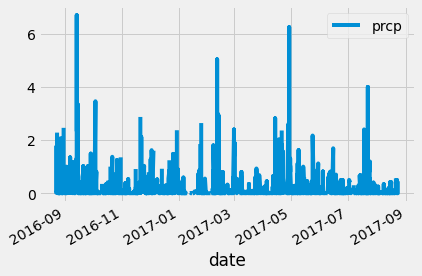

In [51]:
df_sub.set_index("date").plot()

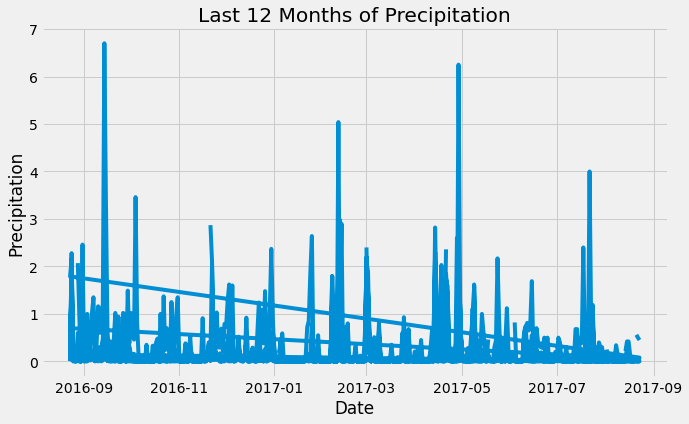

In [57]:
plt.figure(figsize = (10,6))
plt.plot(df_sub.date, df_sub.prcp)
plt.title("Last 12 Months of Precipitation")
plt.xlabel("Date")
plt.ylabel("Precipitation")

plt.show()

In [58]:
# Use Pandas to calcualte the summary statistics for the precipitation data

df_sub.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [65]:
# Design a query to show how many stations are available in this dataset?
query = """
SELECT count(1) as station_count
FROM Station
"""

conn = engine.connect()
df = pd.read_sql(query, con=conn)
conn.close()

df

,station_count
0,9


In [75]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

query = """
SELECT s.Station, COUNT(*) AS activity
FROM Station s 
JOIN Measurement m on s.Station = m.Station
GROUP BY s.Station
ORDER BY COUNT(*) DESC"""

conn = engine.connect()
df = pd.read_sql(query, con=conn)
conn.close()

df

,station,activity
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [76]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

query = """
SELECT s.station, COUNT(*) AS activity
FROM Station s 
JOIN Measurement m on s.station = m.station
GROUP BY s.station
WHERE """

conn = engine.connect()
df = pd.read_sql(query, con=conn)
conn.close()

df

station     USC00519523
activity           2772
dtype: object

In [88]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

query = """
SELECT m.date, m.prcp, m.tobs, s.station, s.name
FROM Measurement m 
JOIN Station s on m.Station = s.Station
WHERE date >= (
    SELECT date(MAX(date), '-365 day')
    FROM Measurement )
ORDER BY date
""" 

conn = engine.connect()
df = pd.read_sql(query, con=conn)
conn.close()

df

,date,prcp,tobs,station,name
0,2016-08-23,0.00,81.0,USC00519397,"WAIKIKI 717.2, HI US"
1,2016-08-23,0.15,76.0,USC00513117,"KANEOHE 838.1, HI US"
2,2016-08-23,0.05,80.0,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US"
3,2016-08-23,NaN,80.0,USC00517948,"PEARL CITY, HI US"
4,2016-08-23,0.02,80.0,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US"
...,...,...,...,...,...
2225,2017-08-22,0.50,76.0,USC00516128,"MANOA LYON ARBO 785.2, HI US"
2226,2017-08-23,0.00,81.0,USC00519397,"WAIKIKI 717.2, HI US"
2227,2017-08-23,0.00,82.0,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US"
2228,2017-08-23,0.08,82.0,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US"


In [90]:
mostactive = df.groupby("station").size().sort_values(ascending = False).index[0]
mostactive

'USC00519397'

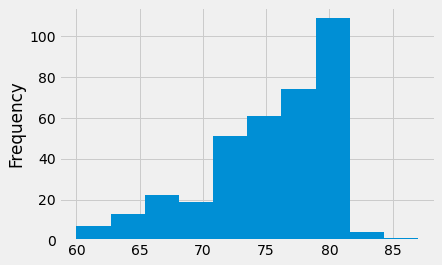

In [96]:
df.loc[df.station == mostactive, "tobs"].reset_index(drop=True).plot(kind = "hist")

In [98]:
df_sub = df.loc[df.station == mostactive].reset_index(drop=True)

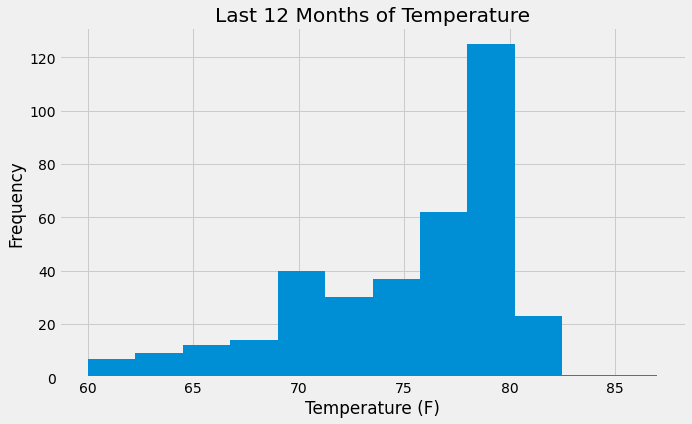

In [101]:
plt.figure(figsize = (10,6))
plt.hist(df_sub.tobs, bins = 12)
plt.title("Last 12 Months of Temperature")
plt.xlabel("Temperature (F)")
plt.ylabel("Frequency")

plt.show()

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
